<a href="https://colab.research.google.com/github/montassar-ML/Energy-project-/blob/main/Fuel_Efficiency_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dataset: Auto MPG**
Dataset Description: The Auto MPG dataset is a classic dataset used in statistical and machine learning to model and predict automobile fuel efficiency based on various attributes of the car.
Attributes Used: The model considers several attributes of vehicles such as:

cylinders: The number of cylinders in the car's engine.

displacement: The volume displaced by the pistons inside the cylinders, typically measured in cubic centimeters or cubic inches.

horsepower: The power output of the engine.

weight: The total weight of the vehicle.
# **Objective**
Fuel Efficiency Prediction: The main goal here is to build a predictive model that can estimate the fuel efficiency (mpg) of cars from the late-1970s and early 1980s based on the attributes mentioned. This is useful for understanding how different factors like engine size, power, and weight impact fuel economy.
# **Methodology**
Building the Model: The process involves feeding the model historical data from the dataset, which includes known values of the mpg for various cars along with their attributes. The model learns to associate these attributes with the mpg and can then predict mpg for new or unseen data with similar attributes.
# **Application**
This kind of modeling is crucial in the automotive industry for designing more fuel-efficient cars and meeting regulatory standards. It can also be used by consumers to make informed choices about vehicle purchases based on expected fuel economy.

In [1]:
# Use seaborn for pairplot
!pip install seaborn

In [2]:
from __future__ import absolute_import, division, print_function

In [3]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
print(tf.__version__)

2.17.0


In [13]:
dataset_path = keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

   8192/Unknown 0s 7us/step

'/root/.keras/datasets/auto-mpg.data'

In [14]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### **Clean the data**

---

The dataset contains a few unknown values.

In [20]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,0
Weight,0
Acceleration,0
Model Year,0
USA,0
Europe,0
Japan,0


To keep this initial tutorial simple drop those rows.

In [16]:
dataset = dataset.dropna()

The "Origin" column is really categorical, not numeric. So convert that to a one-hot:

In [17]:
origin = dataset.pop('Origin')

In [18]:
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


### **Split the data into train and test**
Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [19]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data
Have a quick look at the joint distribution of a few pairs of columns from the training set

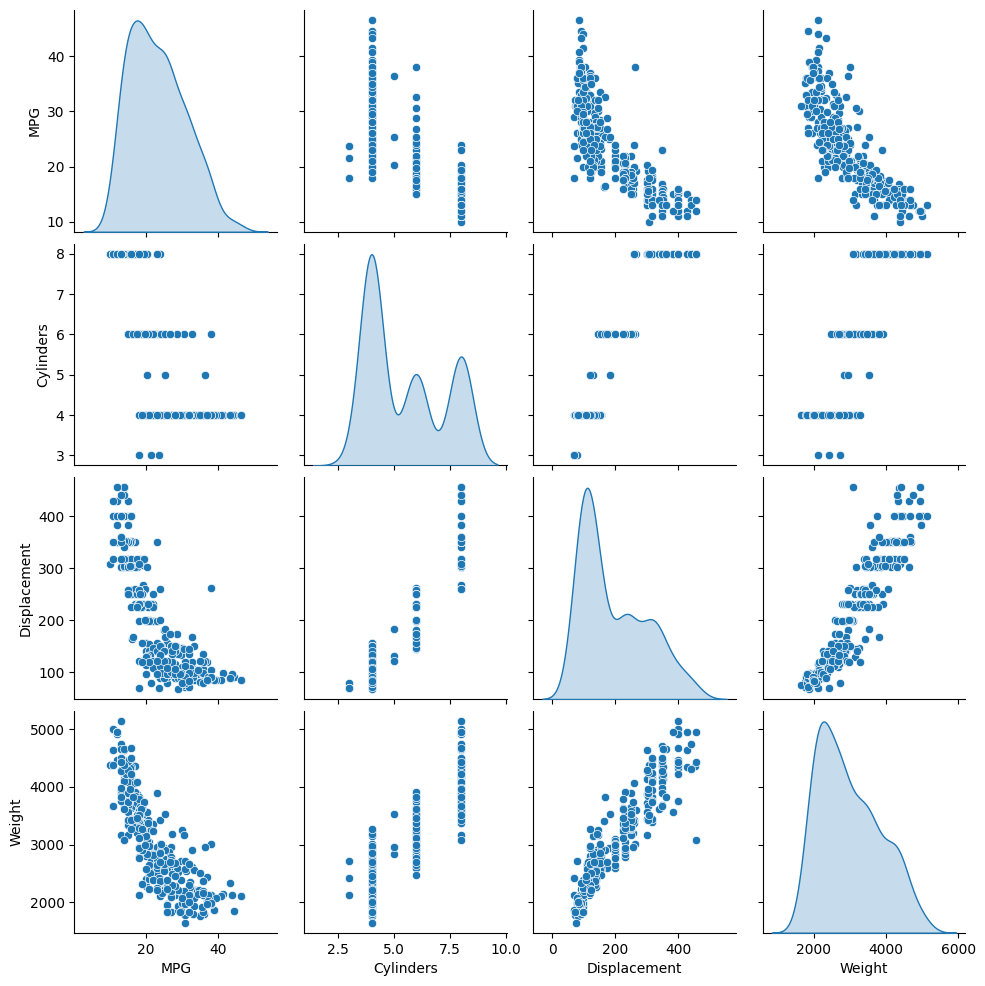

In [21]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

**Diagonal Plots (Distributions)**

Cylinders: The plot shows peaks at specific cylinder counts (4, 6, 8), which
are common configurations in cars.

Displacement and Weight: Both show skewed distributions, suggesting variability in engine size and vehicle weight among the sampled vehicles.



---
Also look at the overall statistics:


In [22]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Split features from labels
Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [23]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

### Normalize the data
Look again at the train_stats block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model might converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [24]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier. That includes the test set as well as live data when the model is used in production.

# The model
### Build the model
Let's build our model. Here, we'll use a Sequential model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, build_model, since we'll create a second model, later on.

In [25]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [26]:
model = build_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Inspect the model

Use the .summary method to print a simple description of the model

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,865 (19.00 KB)

 Trainable params: 4,865 (19.00 KB)

 Non-trainable params: 0 (0.00 B)

Now try out the model. Take a batch of 10 examples from the training data and call model.predict on it.

In [28]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


array([[-0.15559201],
       [ 0.02085654],
       [ 0.2388461 ],
       [-0.08577905],
       [-0.00752287],
       [-0.08677113],
       [-0.01082993],
       [ 0.02669278],
       [-0.05190341],
       [-0.2085543 ]], dtype=float32)

mmm It seems to be working, and it produces a result of the expected shape and type

### Train the model
Train the model for 1000 epochs, and record the training and validation accuracy in the history object.

In [29]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

Visualize the model's training progress using the stats stored in the history object.

In [30]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,2.133551,0.993869,2.133551,10.429818,2.500701,10.429818,995
996,1.848842,0.916134,1.848842,10.473778,2.557212,10.473778,996
997,1.884630,0.900070,1.884630,10.365775,2.491142,10.365775,997
998,1.771964,0.859784,1.771964,10.796375,2.634397,10.796375,998
999,2.032389,0.932321,2.032389,10.005388,2.445093,10.005388,999


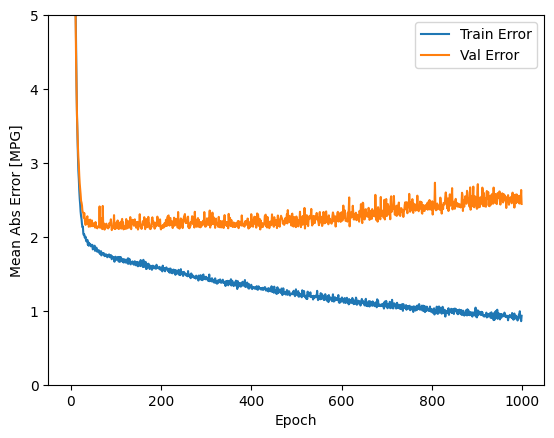

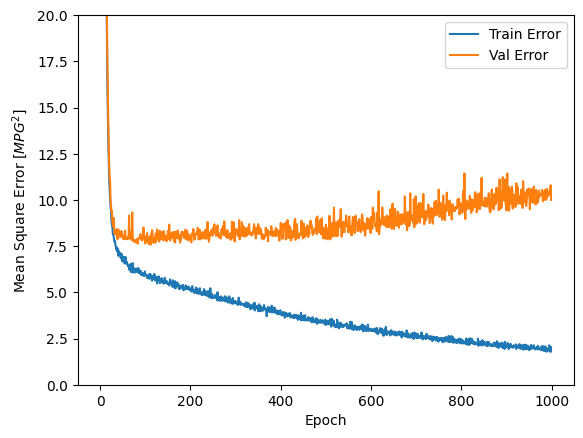

In [31]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the model.fit call to automatically stop training when the validation score doesn't improve. We'll use an EarlyStopping callback that tests a training condition for every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



......................................................

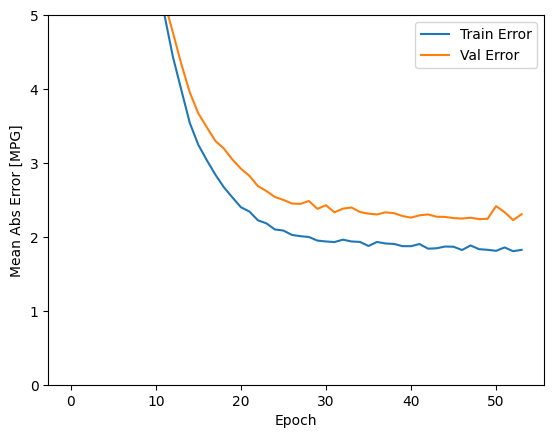

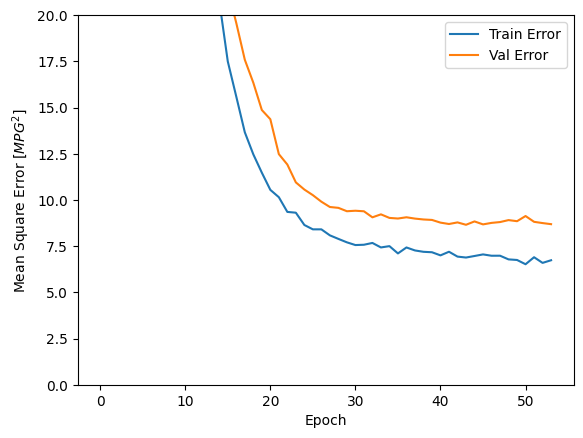

In [32]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [33]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.74 MPG


### Make predictions

Finally, predict MPG values using data in the testing set:

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


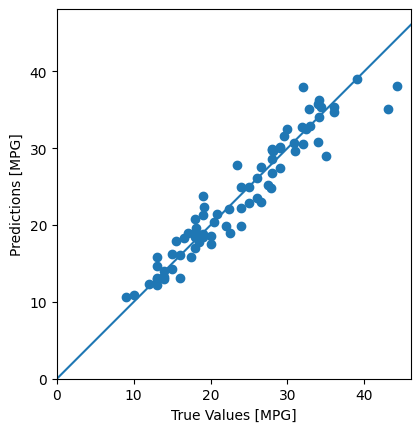

In [34]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

It looks like our model predicts reasonably well. Let's take a look at the error distribution

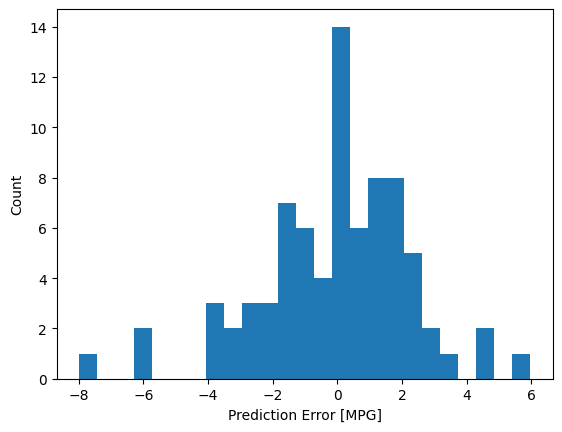

In [35]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

It's not quite gaussian, but we might expect that because the number of samples is very small.

# Conclusion
This notebook introduced a few techniques to handle a regression problem.

Mean Squared Error (MSE) is a common loss function used for regression problems (different loss functions are used for classification problems).
Similarly, evaluation metrics used for regression differ from classification. A common regression metric is Mean Absolute Error (MAE).
When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
If there is not much training data, one technique is to prefer a small network with few hidden layers to avoid overfitting.
Early stopping is a useful technique to prevent overfitting.